In [1]:
import numpy as np
import pandas as pd
import antipickle
from pathlib import Path
import torch
from matplotlib import pyplot as plt

# device = torch.device('cuda:0')
device = torch.device('cpu')

In [2]:
# from collections import Counter
# len([k for k, v in Counter(peptides).most_common() if v > 3])

In [3]:
coloring2colors = np.random.RandomState(42).uniform(size=(1000, 3))

if False:
    # immrep23 dataset does not seem to be 'trainable'.
    vdj_df = pd.read_csv('./VDJdb_paired_chain.csv')
    is_good = ~(vdj_df['CDR3a_extended'].isna() | vdj_df['CDR3b_extended'].isna())
    paired_TRA = vdj_df['CDR3a_extended'][is_good].tolist()
    paired_TRB = vdj_df['CDR3b_extended'][is_good].tolist()
    
    pep_lookup, paired_pep = np.unique(vdj_df['Peptide'][is_good], return_inverse=True)
    peptide_ids = paired_pep
else:
    vdj_df = pd.read_csv('/Users/axelr/Downloads/vdjdb.tsv', sep='\t')

    paired_TRA = []
    paired_TRB = []
    peptides = []
    # [vdj_df['complex.id'] != 0]
    for _, group in vdj_df.groupby('complex.id'):
        # print(group)
        if len(group) < 2:
            continue
        if len(group) != 2:
            continue
        if group['Score'].iloc[0] == 0:
            continue
    
        group = group.sort_values(by='Gene')
        _tra, _trb = group['CDR3']
    
        paired_TRA.append(_tra)
        paired_TRB.append(_trb)  
        peptides.append(group['Epitope'].iloc[0])
        
    pep_lookup, paired_pep = np.unique(peptides, return_inverse=True)
    peptide_ids = paired_pep

_m = np.bincount(peptide_ids) > 4
coloring2colors[:len(_m)] = coloring2colors[:len(_m)] * _m[:, None]

In [4]:
# np.sort(np.unique(paired_pep, return_counts=True)[1])[::-1]

## Part2. Analysis

In [5]:
# path = Path('/data/analysis/vdjdb_sequences_embedded_by_esm2.antipickle')
# seq2emb = antipickle.load(path)

## Matching classifier

In [6]:
for x in [*paired_TRA, *paired_TRB]:
    assert isinstance(x, str), [type(x), x]

In [7]:
models = ['esm', 'counts', 'onehot']

In [8]:
from collections import Counter

In [9]:
def kmers(seq: str, k=3) -> list[str]:
    return [seq[i:i+k] for i in range(len(seq) - k + 1)]

def make_vocabulary(seq: list[str], k) -> dict[str, int]:
    mapping = {}
    for s in seq:
        for kmer in kmers(s, k):
            if kmer not in mapping:
                mapping[kmer] = len(mapping)
    return mapping

def make_prioritized_vocabulary(seq: list[str], K, minimal=3) -> dict[str, int]:
    counter = Counter()
    for k in range(3, K + 1):
        for s in seq:
            for kmer in kmers(s, k):
                counter[kmer] += 1
    _kmers = [kmer for kmer, count in counter.items() if count >= minimal]
    return {kmer: i for i, kmer in enumerate(_kmers)}

def count_kmers(seq: list[str], k) -> dict[str, int]:
    counter = Counter()
    for s in seq:
        for kmer in kmers(s, k):
            counter[kmer] += 1
    return counter

def featurize(mapping, seqs: list[str], K: int) -> np.ndarray:
    result = np.zeros([len(seqs), len(mapping)], dtype='float32')
    if isinstance(K, int):
        kmin, kmax = K, K
    else:
        kmin, kmax = K
    for i, seq in enumerate(seqs):
        for k in range(kmin, kmax + 1):
            for kmer in kmers(seq, k):
                if kmer in mapping:
                    result[i, mapping[kmer]] += 1
    return result

In [10]:
ALPHABET = ' ACDEFGHIKLMNPQRSTVWY'
letter2id = {letter: i for i, letter in enumerate(ALPHABET)}
letter2array = {letter: array for letter, array in zip(ALPHABET, np.eye(len(ALPHABET)).astype('float32'), strict=True)}

def to_onehot(seq):
    # pad everything to 27 length
    x = np.stack([letter2array[letter] for letter in ' ' + seq + ' ' * (26 - len(seq))])
    return x

In [11]:
method = 'onehot'

match method:
    case 'esm':
        embs_tcra = np.stack([seq2emb[seq] for seq in paired_TRA])
        embs_tcrb = np.stack([seq2emb[seq] for seq in paired_TRB])
    case 'counts':
        if False:
            K = 4
            _mapping = make_vocabulary([*paired_TRA, *paired_TRB], k=K)
            embs_tcra = featurize(_mapping, paired_TRA, K=K)
            embs_tcrb = featurize(_mapping, paired_TRB, K=K)
        else:
            _mapping = make_prioritized_vocabulary([*paired_TRA, *paired_TRB], K=4, minimal=3)
            embs_tcra = featurize(_mapping, paired_TRA, K=(3, 5))
            embs_tcrb = featurize(_mapping, paired_TRB, K=(3, 5))
            
        print('counts')
    case 'onehot':
        embs_tcra = np.stack([to_onehot(x) for x in paired_TRA])
        embs_tcrb = np.stack([to_onehot(x) for x in paired_TRB])
    case _:
        raise RuntimeError()

In [12]:
from einops.layers.torch import Rearrange, Reduce

In [13]:
match method:
    case 'esm' | 'counts':
        emb_size = embs_tcra.shape[1]
        model = torch.nn.Sequential(
            # torch.nn.BatchNorm1d(emb_size),
            torch.nn.Dropout(0.6),
            torch.nn.Linear(emb_size, 512),
            torch.nn.Dropout(0.25),
            torch.nn.PReLU(),
            torch.nn.Linear(512, 512),
        ).to(device)
    case 'onehot':
        _, _, emb_size = embs_tcra.shape
        model = torch.nn.Sequential(
            Rearrange('b t c -> b c t'),
            # torch.nn.BatchNorm1d(emb_size),
            torch.nn.Conv1d(emb_size, 64, kernel_size=4),
            torch.nn.BatchNorm1d(64),
            Rearrange('b c t -> b t c'),
            torch.nn.TransformerEncoderLayer(batch_first=True, nhead=1, d_model=64, dim_feedforward=128),
            Rearrange('b t c -> b c t'),
            # torch.nn.PReLU(),
            torch.nn.Conv1d(64, 128, kernel_size=5),
            torch.nn.PReLU(),
            Reduce('b c t -> b c', reduction='mean'),
            torch.nn.Linear(128, 128),
        ).to(device)

In [14]:
# model(torch.zeros(3, 100, 27)).shape

In [15]:
import umap

In [16]:
# from matplotlib import pyplot as plt
# plt.scatter(
#     np.random.random(100), 
#     np.random.random(100), 
#     c=np.random.random(size=(100, 3)) * 1., 
#     cmap='tab20c',
# )

In [17]:
from sklearn.manifold import TSNE
def visualize(embs, coloring):
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        reducer = TSNE(init='pca', learning_rate='auto', random_state=42)
        [x, y] = reducer.fit_transform(embs).T
    fig, ax = plt.subplots(dpi=200)
    ax.scatter(x, y, c=coloring2colors[coloring], s=1.) # cmap='tab20c',
    ax.set_title(f'Iteration = {iteration:>5}')
    plt.show()

In [18]:
optim = torch.optim.AdamW(model.parameters(), lr=3e-3 if method == 'onehot' else 1e-3)

In [19]:
def compute_loss(indices):
    left_emb = model(torch.from_numpy(embs_tcra[indices]).to(device))
    rght_emb = model(torch.from_numpy(embs_tcrb[indices]).to(device))
    pepts = peptide_ids[indices]

    logits = torch.einsum('i c, j c -> i j', left_emb, rght_emb)
    target = torch.arange(len(indices), device=device)
    loss_left = torch.nn.functional.cross_entropy(logits, target)
    loss_rght = torch.nn.functional.cross_entropy(logits.T, target)

    probs = torch.softmax(logits, dim=0) + torch.softmax(logits, dim=1)

    fraction = probs[pepts[:, None] == pepts[None, :]].sum() / probs.sum()
    # Best plots are from left + right ... of course.
    plotted_emb = left_emb * 0 + rght_emb
    
    return plotted_emb, logits, (loss_left + loss_rght) * 0.5, fraction

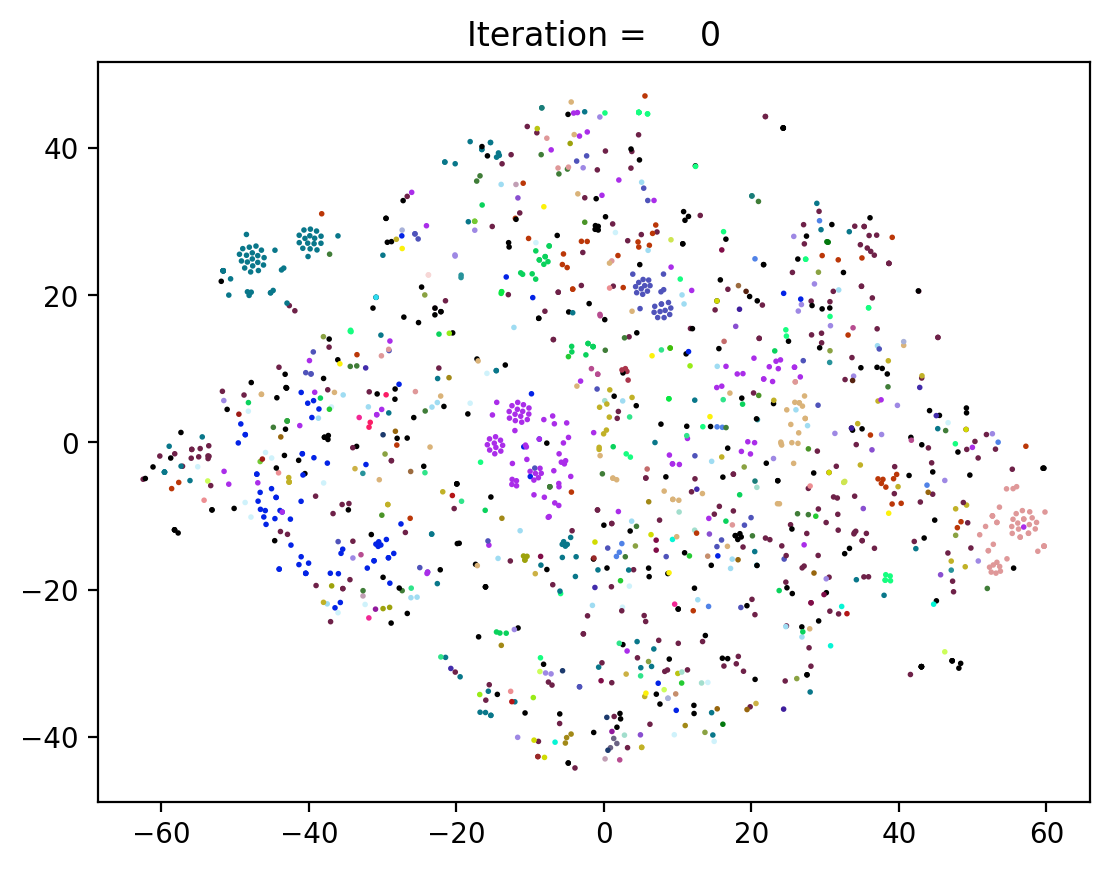

    0 --   7.27  --   7.29 --  0.052  


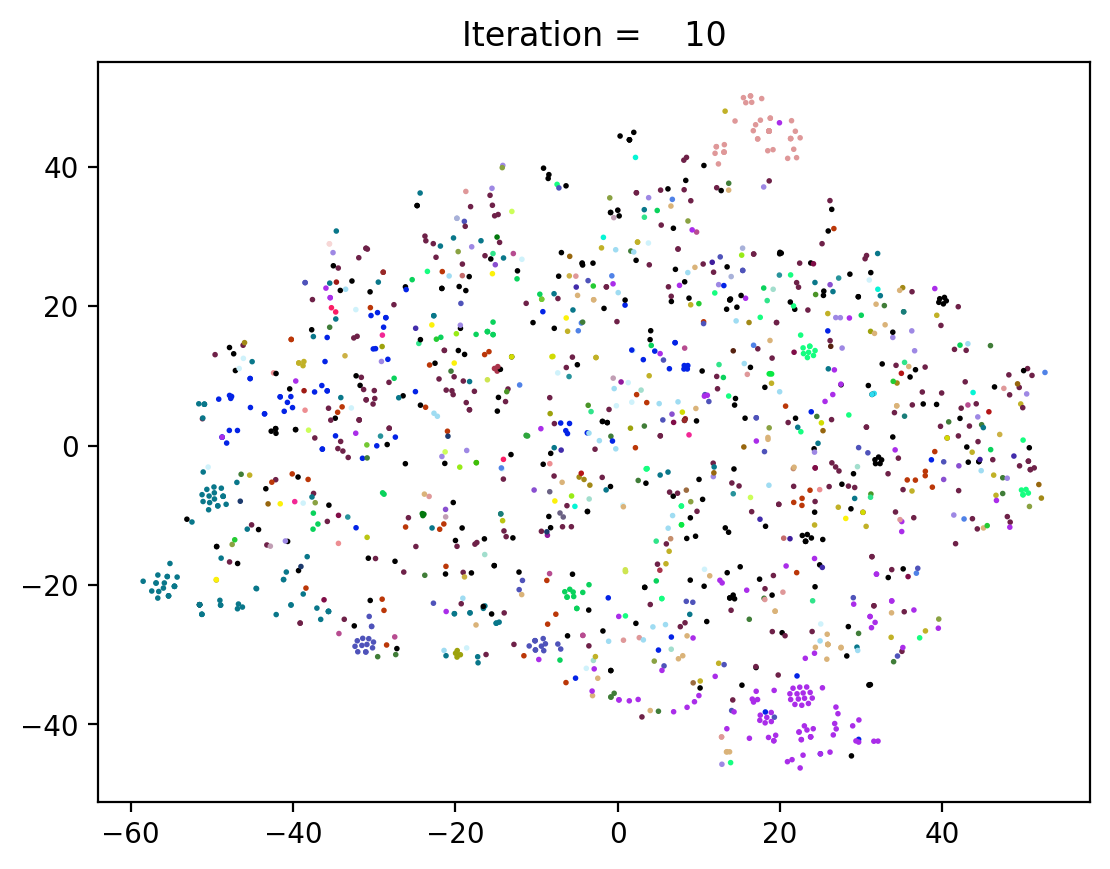

   10 --   7.14  --   7.19 --  0.057  


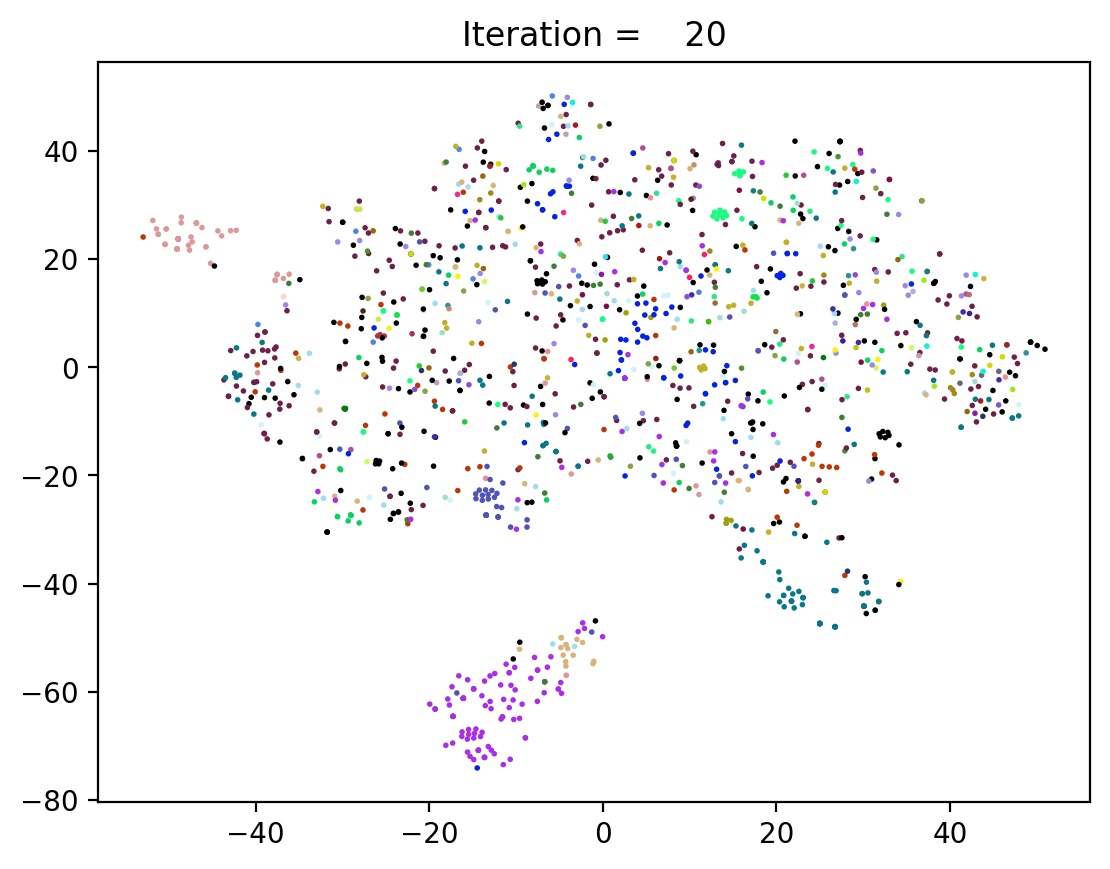

   20 --   6.87  --   7.04 --  0.073  
   30 --   6.54  --   6.86 --  0.138  


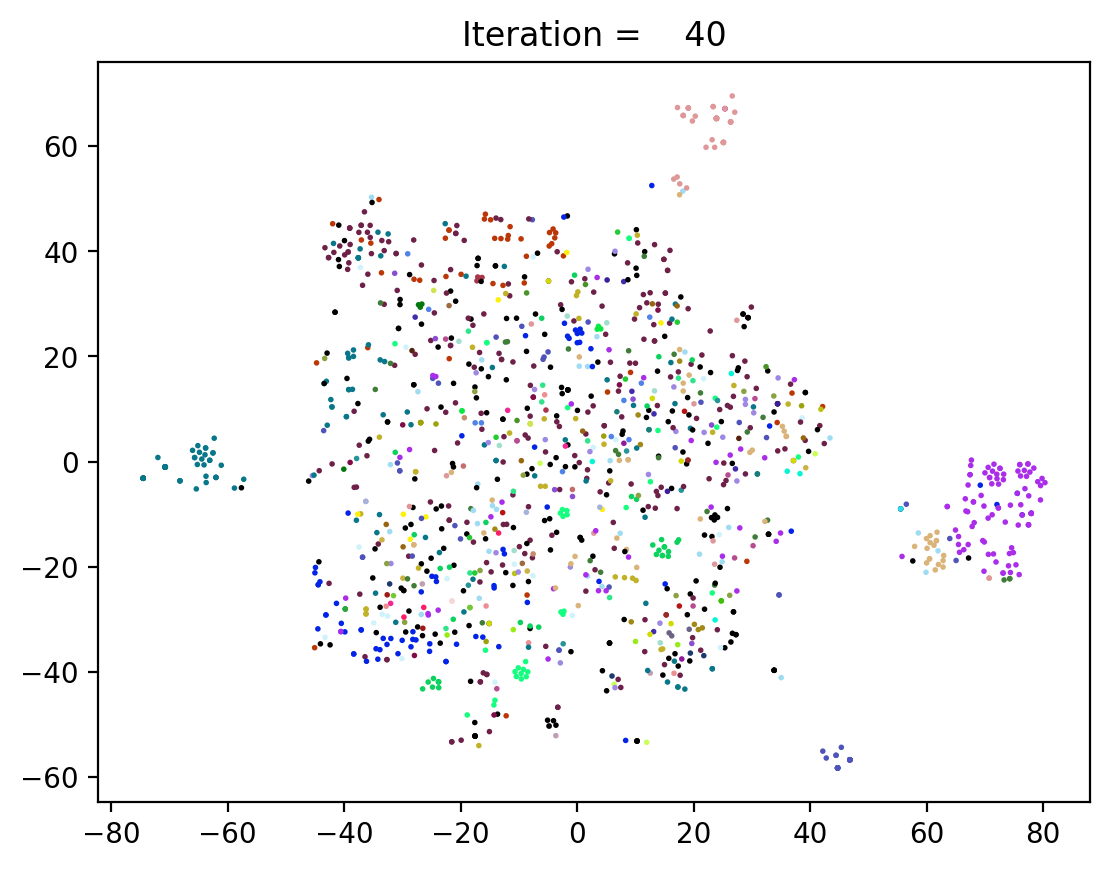

   40 --   6.23  --   6.82 --  0.174  
   50 --   5.90  --   6.88 --  0.180  
   60 --   5.57  --   6.94 --  0.188  


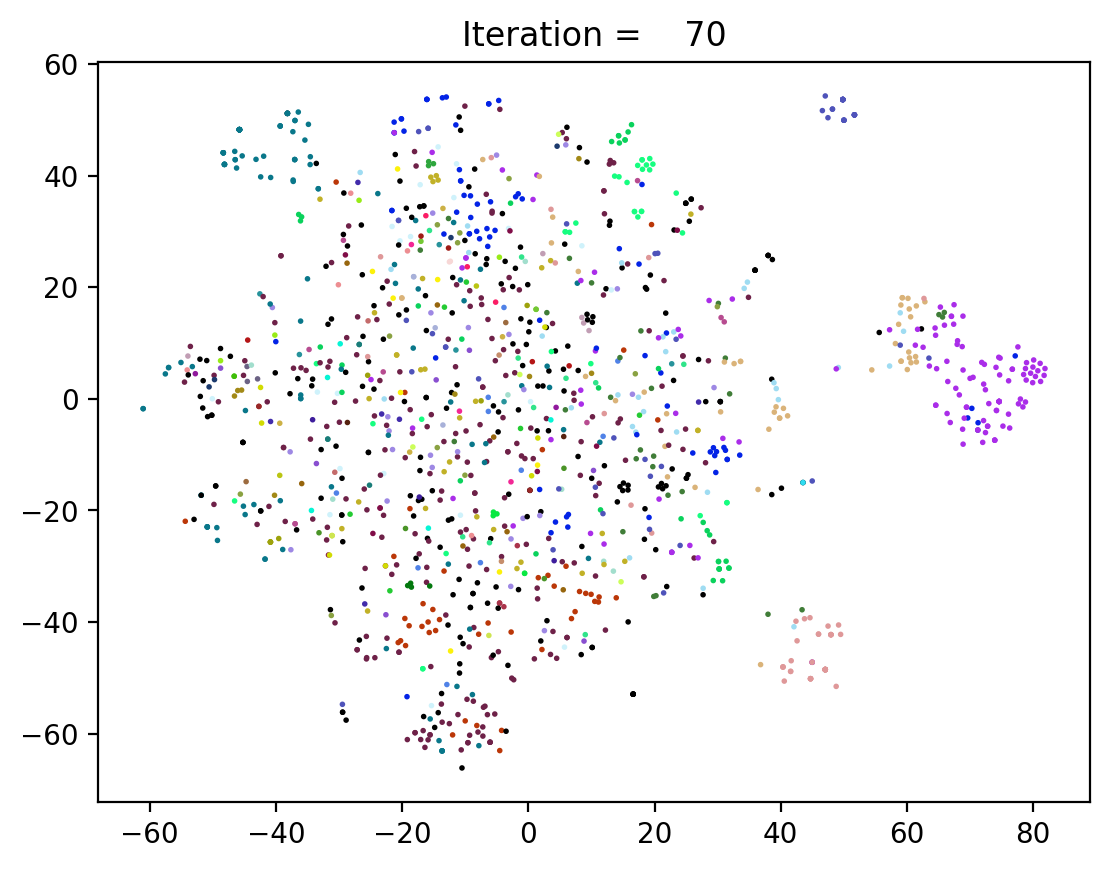

   70 --   5.26  --   7.05 --  0.197  
   80 --   4.86  --   7.02 --  0.212  
   90 --   4.66  --   7.05 --  0.222  


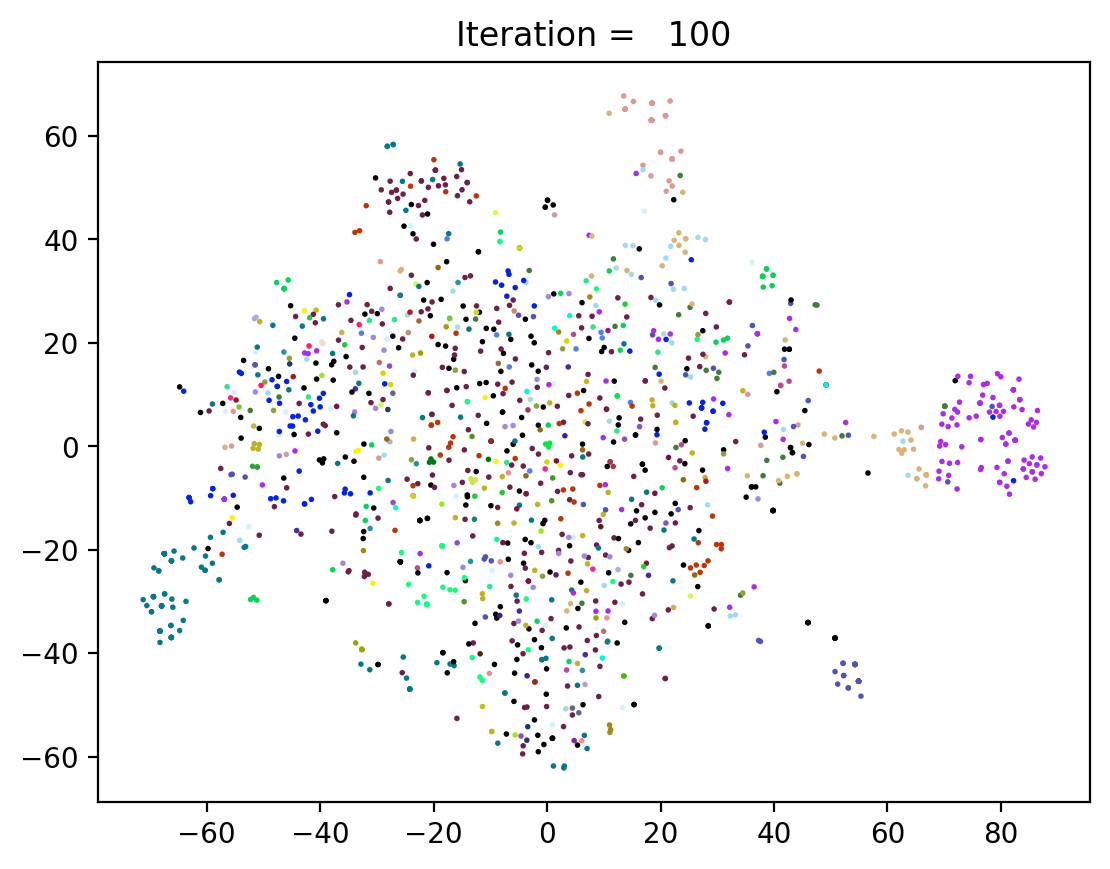

  100 --   4.25  --   7.35 --  0.226  
  110 --   4.01  --   7.70 --  0.237  
  120 --   3.62  --   7.85 --  0.236  
  130 --   3.39  --   8.17 --  0.244  
  140 --   3.13  --   8.34 --  0.245  
  150 --   2.92  --   8.91 --  0.246  
  160 --   2.57  --   9.12 --  0.259  
  170 --   2.36  --   9.67 --  0.260  
  180 --   2.14  --  10.08 --  0.271  
  190 --   2.00  --  10.42 --  0.282  


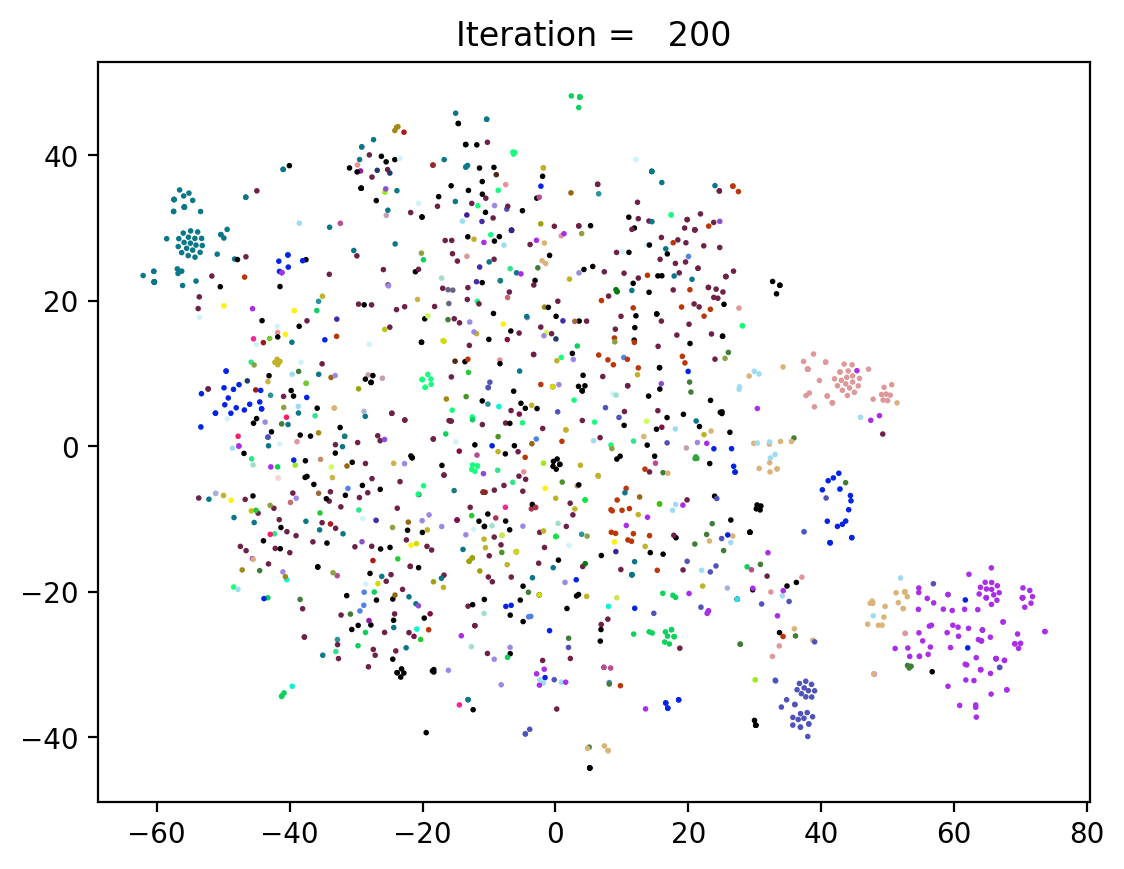

  200 --   1.89  --  10.69 --  0.285  
  210 --   1.67  --  10.93 --  0.301  
  220 --   1.59  --  11.32 --  0.311  
  230 --   1.47  --  11.23 --  0.321  
  240 --   1.45  --  11.46 --  0.315  
  250 --   1.34  --  11.30 --  0.315  
  260 --   1.31  --  11.40 --  0.326  
  270 --   1.27  --  11.31 --  0.330  
  280 --   1.26  --  11.22 --  0.329  
  290 --   1.21  --  11.32 --  0.345  


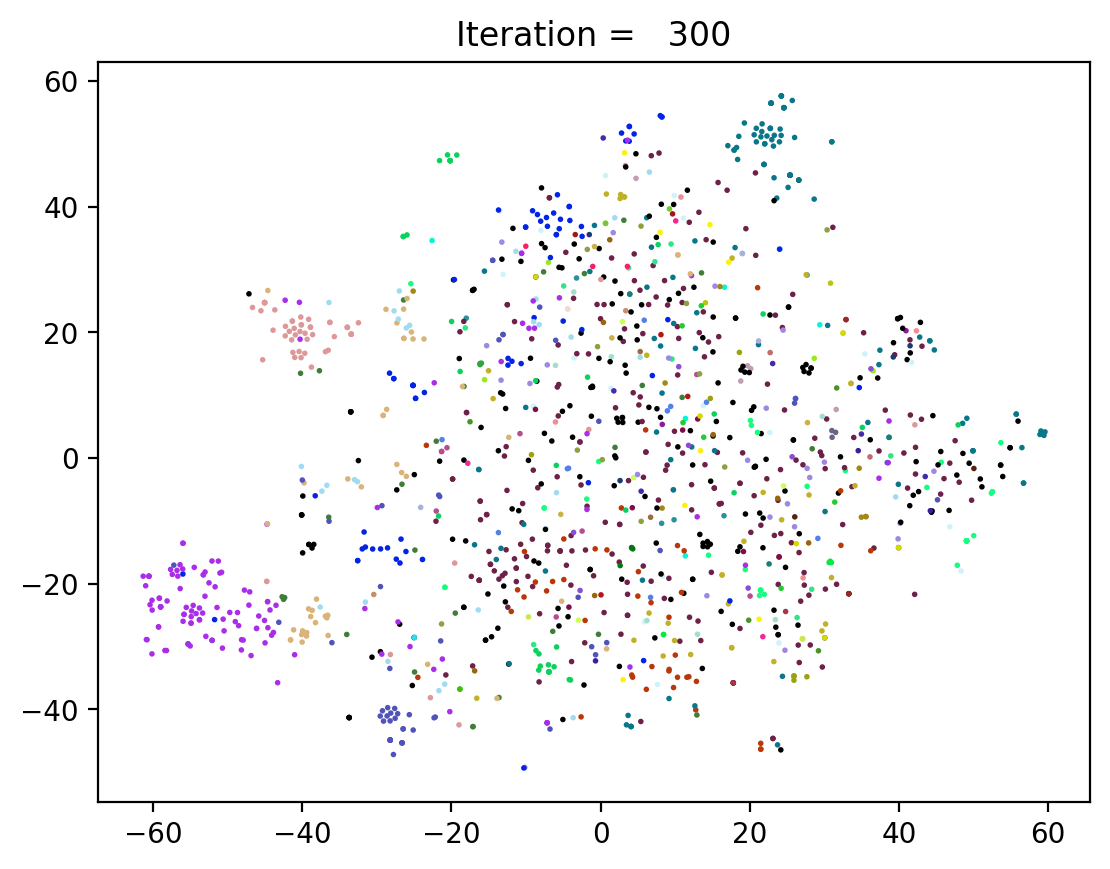

  300 --   1.23  --  11.46 --  0.330  
  310 --   1.17  --  10.96 --  0.349  
  320 --   1.16  --  11.44 --  0.344  
  330 --   1.16  --  11.33 --  0.354  
  340 --   1.13  --  11.26 --  0.355  
  350 --   1.07  --  11.25 --  0.351  
  360 --   1.05  --  11.18 --  0.358  
  370 --   1.06  --  11.24 --  0.355  
  380 --   1.06  --  11.20 --  0.342  
  390 --   1.05  --  11.15 --  0.362  


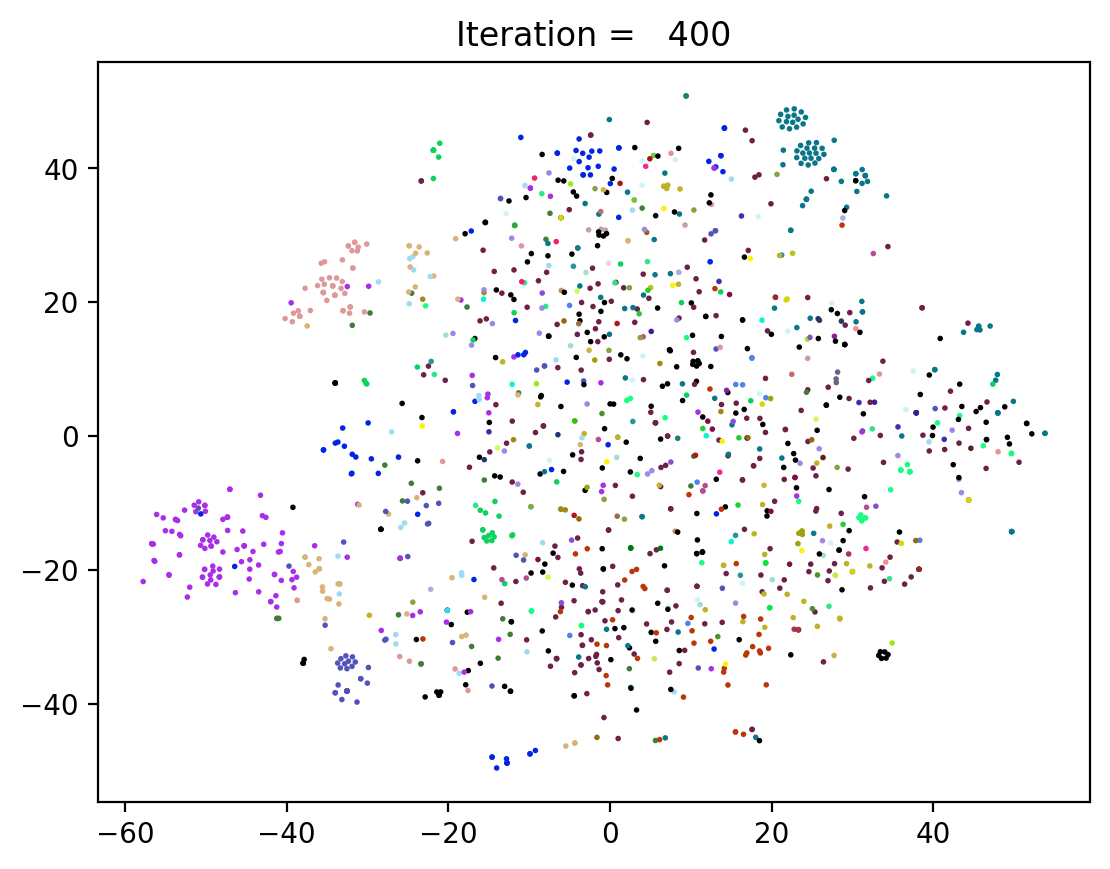

  400 --   1.05  --  10.98 --  0.347  
  410 --   1.03  --  11.12 --  0.355  
  420 --   1.04  --  11.09 --  0.355  
  430 --   0.99  --  11.14 --  0.361  
  440 --   1.00  --  10.96 --  0.365  
  450 --   0.99  --  11.12 --  0.363  
  460 --   0.98  --  11.15 --  0.358  
  470 --   0.99  --  11.17 --  0.371  
  480 --   0.97  --  11.05 --  0.369  
  490 --   0.97  --  11.09 --  0.369  


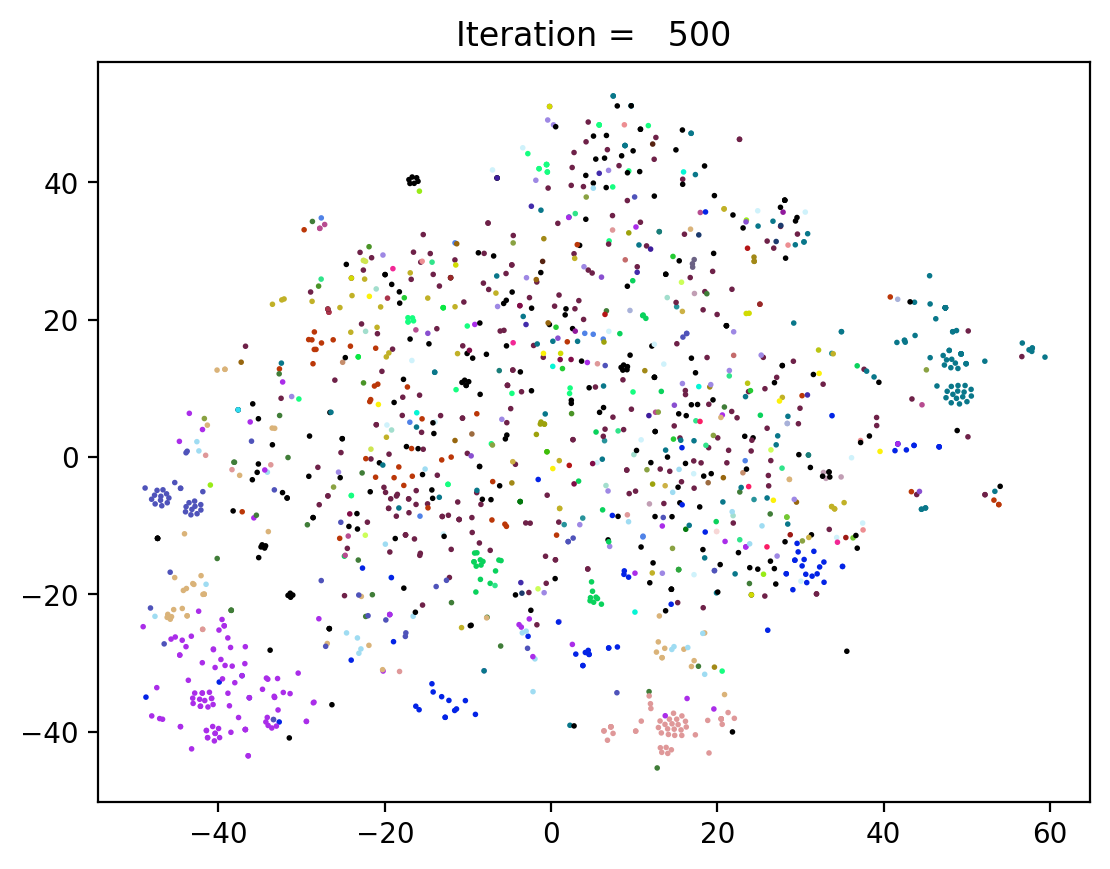

  500 --   0.98  --  10.89 --  0.366  
  510 --   0.95  --  10.83 --  0.375  
  520 --   0.96  --  10.87 --  0.364  
  530 --   0.97  --  10.88 --  0.369  
  540 --   0.95  --  10.99 --  0.367  
  550 --   0.96  --  11.03 --  0.367  
  560 --   0.95  --  11.02 --  0.372  
  570 --   0.94  --  10.89 --  0.374  
  580 --   0.94  --  10.91 --  0.381  
  590 --   0.93  --  10.94 --  0.383  


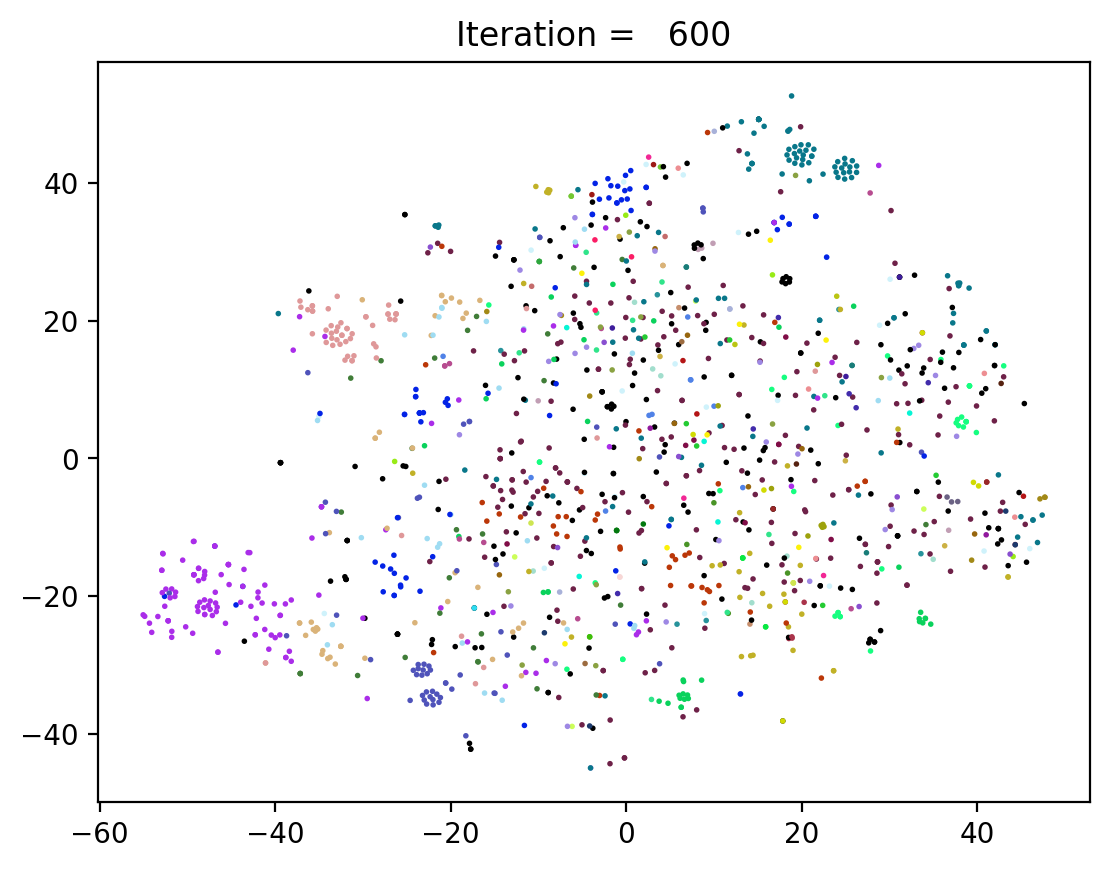

  600 --   0.94  --  10.83 --  0.371  
  610 --   0.93  --  10.96 --  0.379  
  620 --   0.92  --  10.71 --  0.380  
  630 --   0.92  --  11.01 --  0.378  
  640 --   0.93  --  10.89 --  0.384  
  650 --   0.90  --  10.92 --  0.381  
  660 --   0.93  --  10.90 --  0.375  
  670 --   0.92  --  10.88 --  0.375  
  680 --   0.91  --  10.87 --  0.375  
  690 --   0.91  --  10.93 --  0.371  


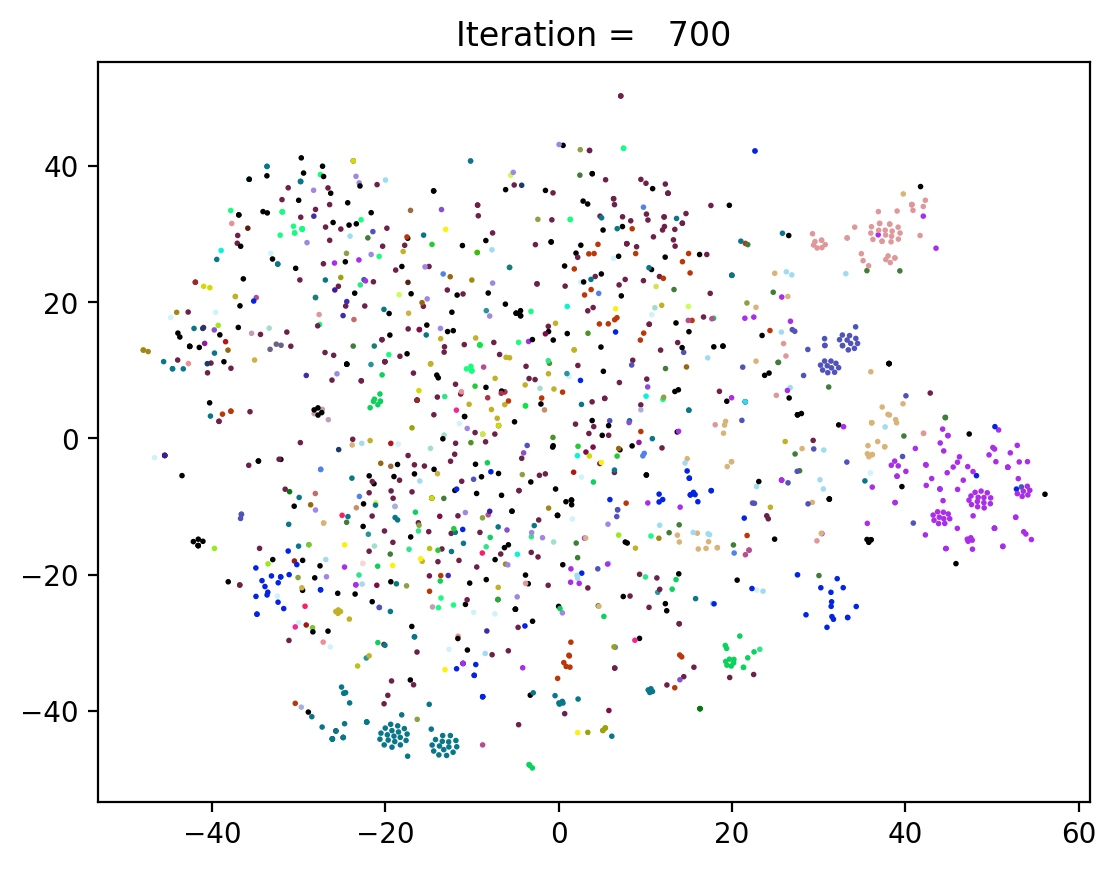

  700 --   0.91  --  10.86 --  0.371  
  710 --   0.90  --  10.79 --  0.372  
  720 --   0.89  --  10.88 --  0.375  
  730 --   0.90  --  10.95 --  0.369  
  740 --   0.91  --  10.88 --  0.380  
  750 --   0.89  --  10.84 --  0.374  
  760 --   0.90  --  10.84 --  0.369  
  770 --   0.91  --  10.87 --  0.367  
  780 --   0.90  --  10.83 --  0.386  
  790 --   0.90  --  10.82 --  0.387  


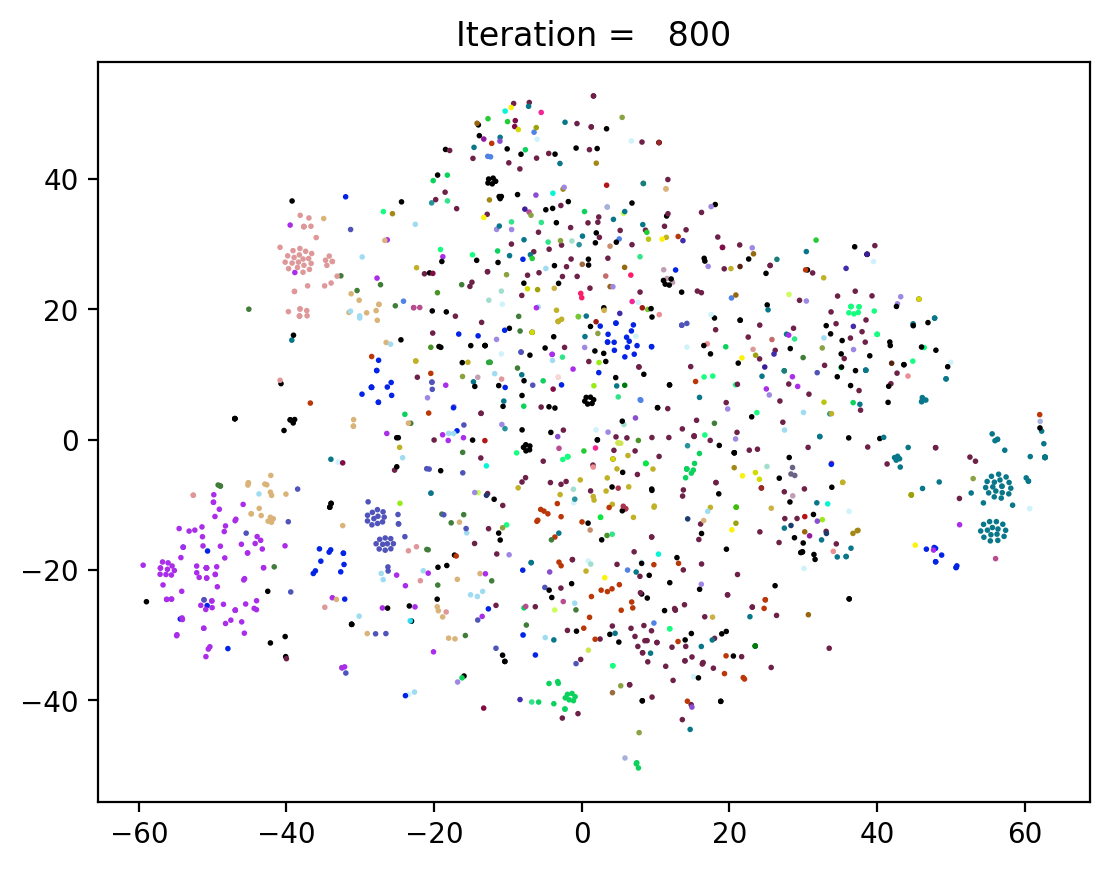

  800 --   0.90  --  10.77 --  0.385  
  810 --   0.90  --  10.75 --  0.381  
  820 --   0.89  --  10.80 --  0.383  
  830 --   0.89  --  10.69 --  0.387  
  840 --   0.88  --  10.62 --  0.387  
  850 --   0.88  --  10.78 --  0.382  
  860 --   0.88  --  10.66 --  0.384  
  870 --   0.88  --  10.74 --  0.379  
  880 --   0.88  --  10.81 --  0.378  
  890 --   0.88  --  10.87 --  0.383  


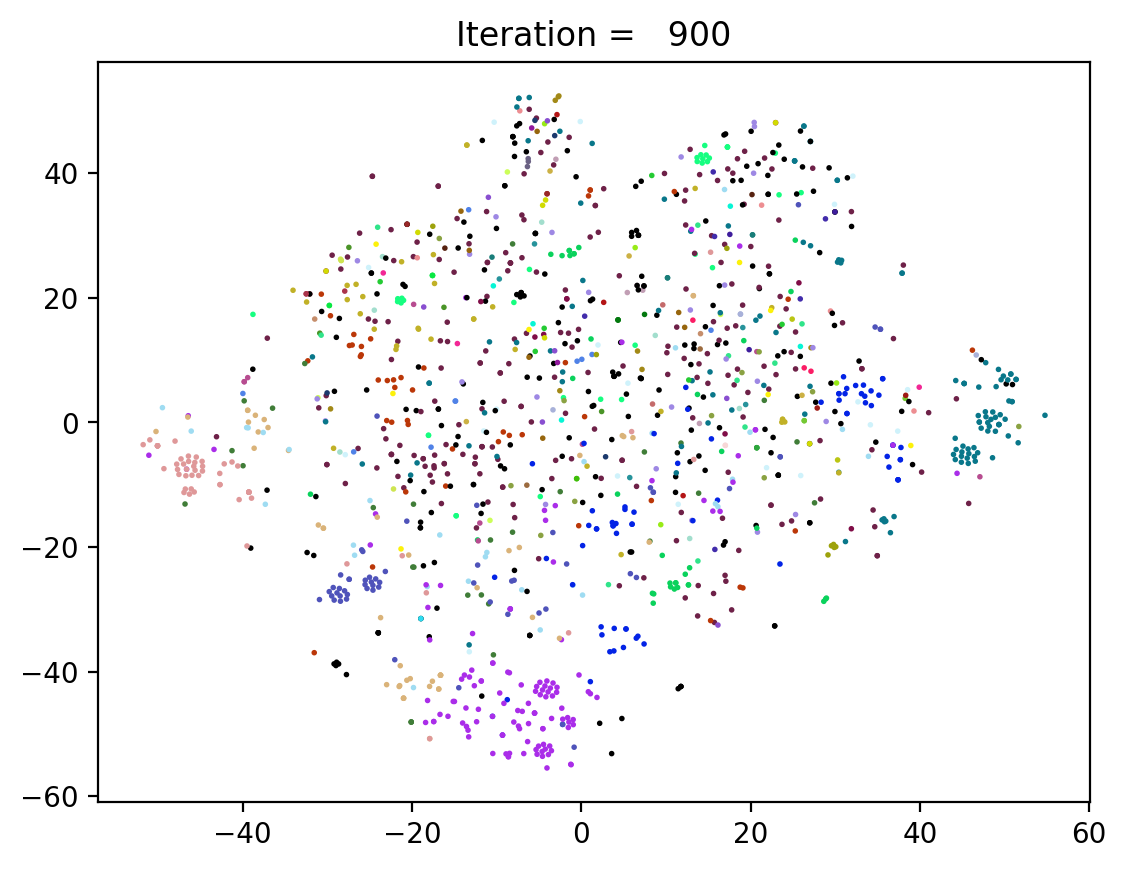

  900 --   0.87  --  10.75 --  0.383  
  910 --   0.87  --  10.74 --  0.389  
  920 --   0.87  --  10.58 --  0.390  
  930 --   0.86  --  10.55 --  0.386  
  940 --   0.86  --  10.68 --  0.387  
  950 --   0.88  --  10.70 --  0.382  
  960 --   0.87  --  10.66 --  0.382  
  970 --   0.88  --  10.68 --  0.383  
  980 --   0.86  --  10.76 --  0.384  
  990 --   0.87  --  10.54 --  0.384  


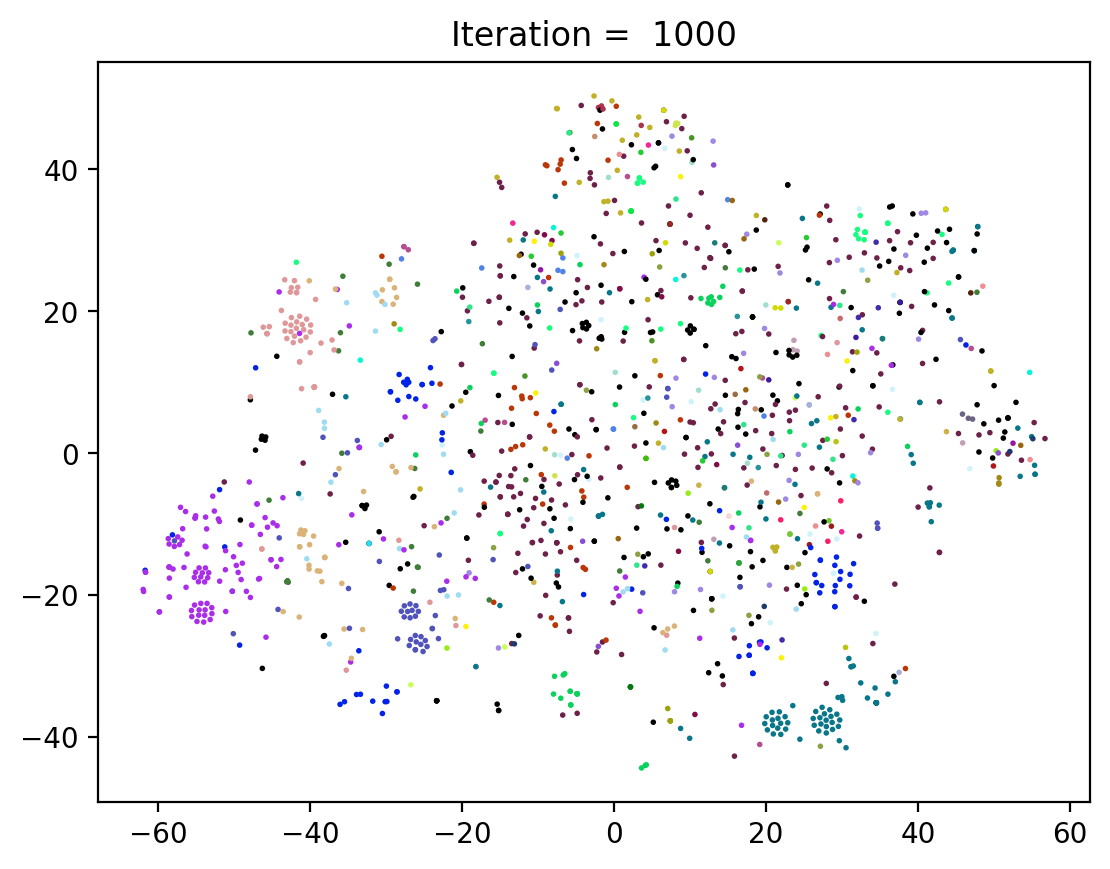

 1000 --   0.86  --  10.56 --  0.382  
 1010 --   0.87  --  10.62 --  0.391  
 1020 --   0.87  --  10.56 --  0.392  
 1030 --   0.87  --  10.54 --  0.391  
 1040 --   0.85  --  10.67 --  0.399  
 1050 --   0.86  --  10.50 --  0.392  
 1060 --   0.86  --  10.61 --  0.397  
 1070 --   0.86  --  10.56 --  0.392  
 1080 --   0.86  --  10.57 --  0.391  
 1090 --   0.86  --  10.55 --  0.395  


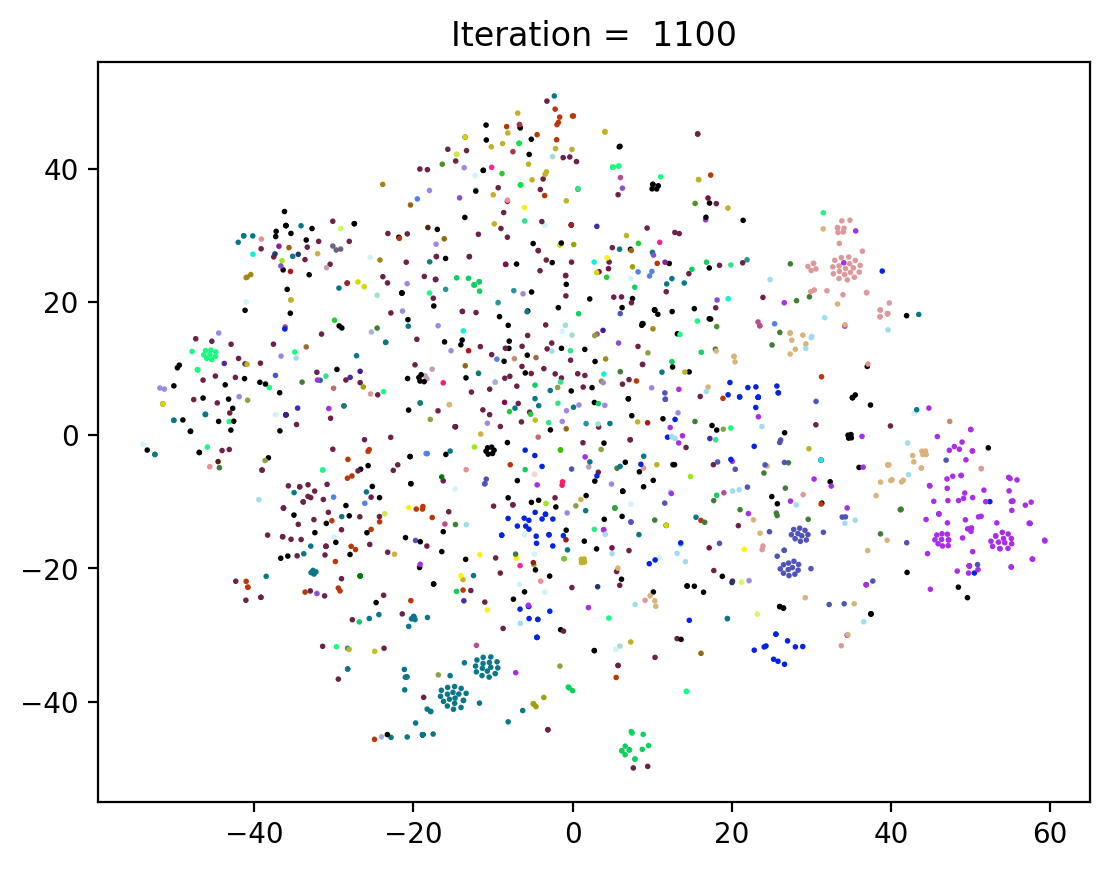

 1100 --   0.85  --  10.49 --  0.399  
 1110 --   0.86  --  10.68 --  0.396  
 1120 --   0.85  --  10.63 --  0.392  
 1130 --   0.85  --  10.61 --  0.393  
 1140 --   0.86  --  10.70 --  0.389  
 1150 --   0.86  --  10.60 --  0.393  
 1160 --   0.85  --  10.72 --  0.400  
 1170 --   0.86  --  10.57 --  0.395  
 1180 --   0.85  --  10.53 --  0.396  
 1190 --   0.85  --  10.61 --  0.388  


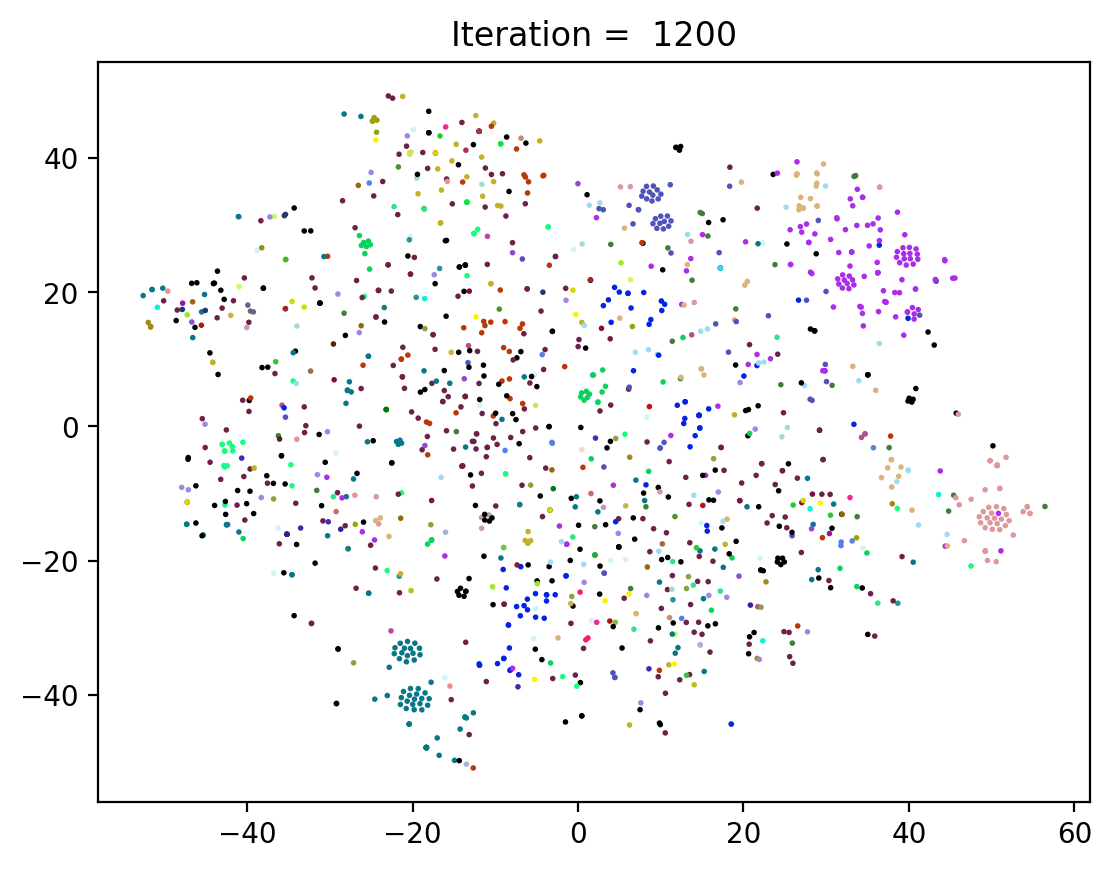

 1200 --   0.85  --  10.59 --  0.394  
 1210 --   0.84  --  10.67 --  0.397  
 1220 --   0.85  --  10.57 --  0.396  
 1230 --   0.85  --  10.60 --  0.398  
 1240 --   0.85  --  10.44 --  0.393  
 1250 --   0.83  --  10.52 --  0.398  
 1260 --   0.84  --  10.51 --  0.394  
 1270 --   0.84  --  10.44 --  0.394  
 1280 --   0.85  --  10.49 --  0.392  
 1290 --   0.84  --  10.64 --  0.402  


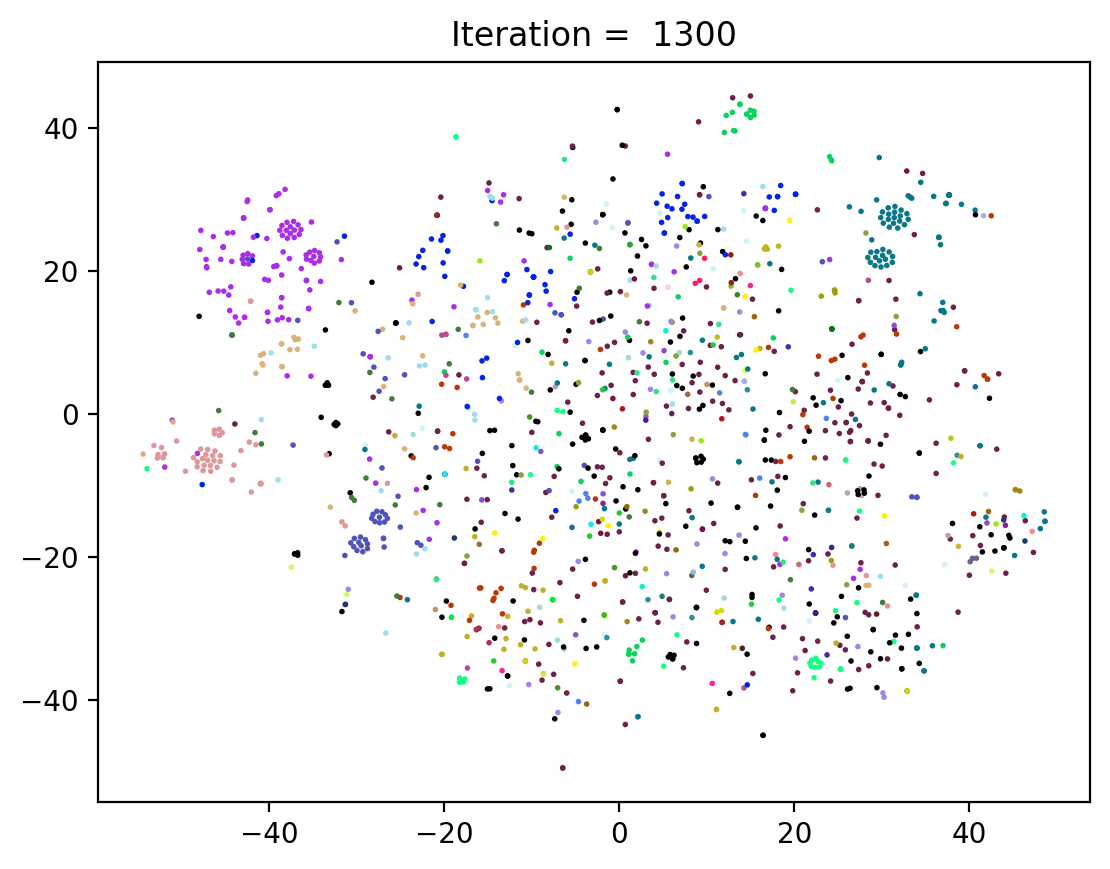

 1300 --   0.85  --  10.50 --  0.396  
 1310 --   0.85  --  10.64 --  0.401  
 1320 --   0.85  --  10.65 --  0.396  
 1330 --   0.84  --  10.54 --  0.400  
 1340 --   0.84  --  10.68 --  0.397  
 1350 --   0.84  --  10.65 --  0.394  
 1360 --   0.84  --  10.62 --  0.399  
 1370 --   0.84  --  10.58 --  0.394  
 1380 --   0.84  --  10.62 --  0.390  
 1390 --   0.83  --  10.60 --  0.405  


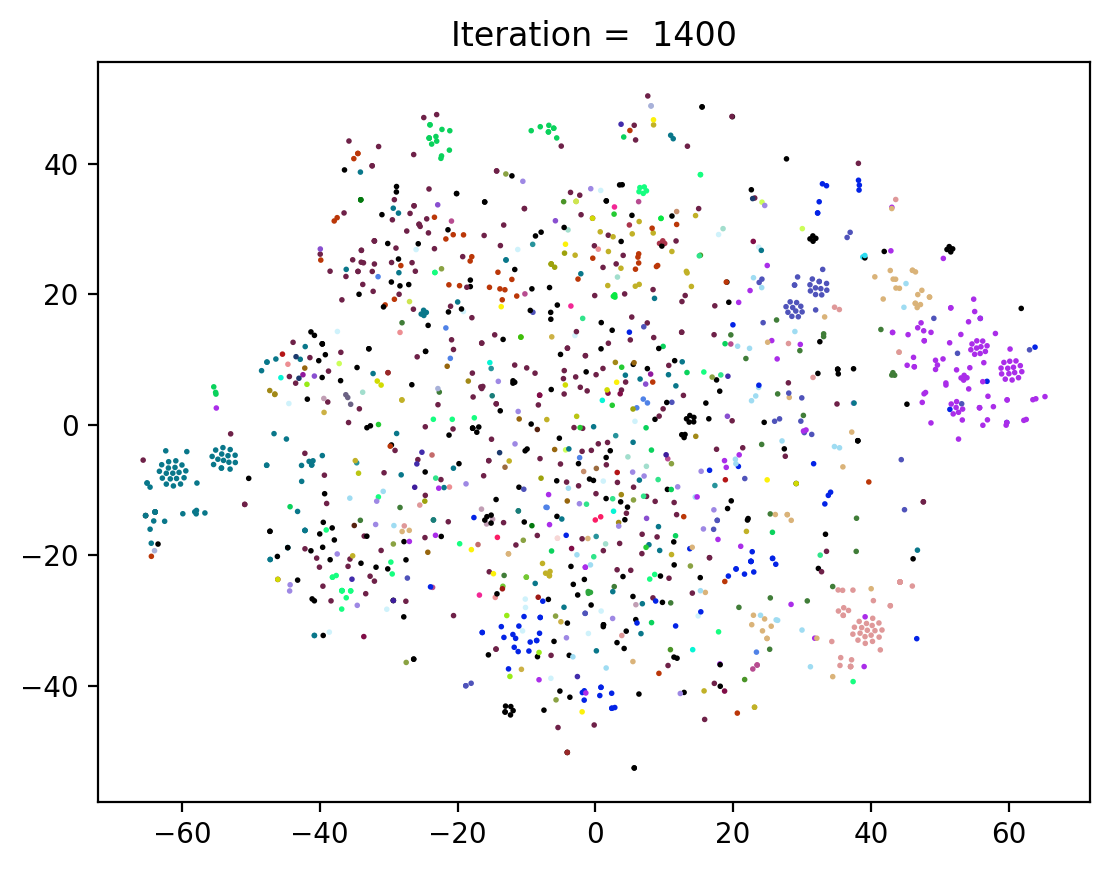

 1400 --   0.83  --  10.50 --  0.400  
 1410 --   0.84  --  10.65 --  0.395  
 1420 --   0.84  --  10.44 --  0.396  
 1430 --   0.83  --  10.53 --  0.396  
 1440 --   0.83  --  10.60 --  0.397  
 1450 --   0.83  --  10.68 --  0.397  
 1460 --   0.84  --  10.60 --  0.394  
 1470 --   0.83  --  10.61 --  0.403  
 1480 --   0.83  --  10.50 --  0.399  
 1490 --   0.83  --  10.57 --  0.405  


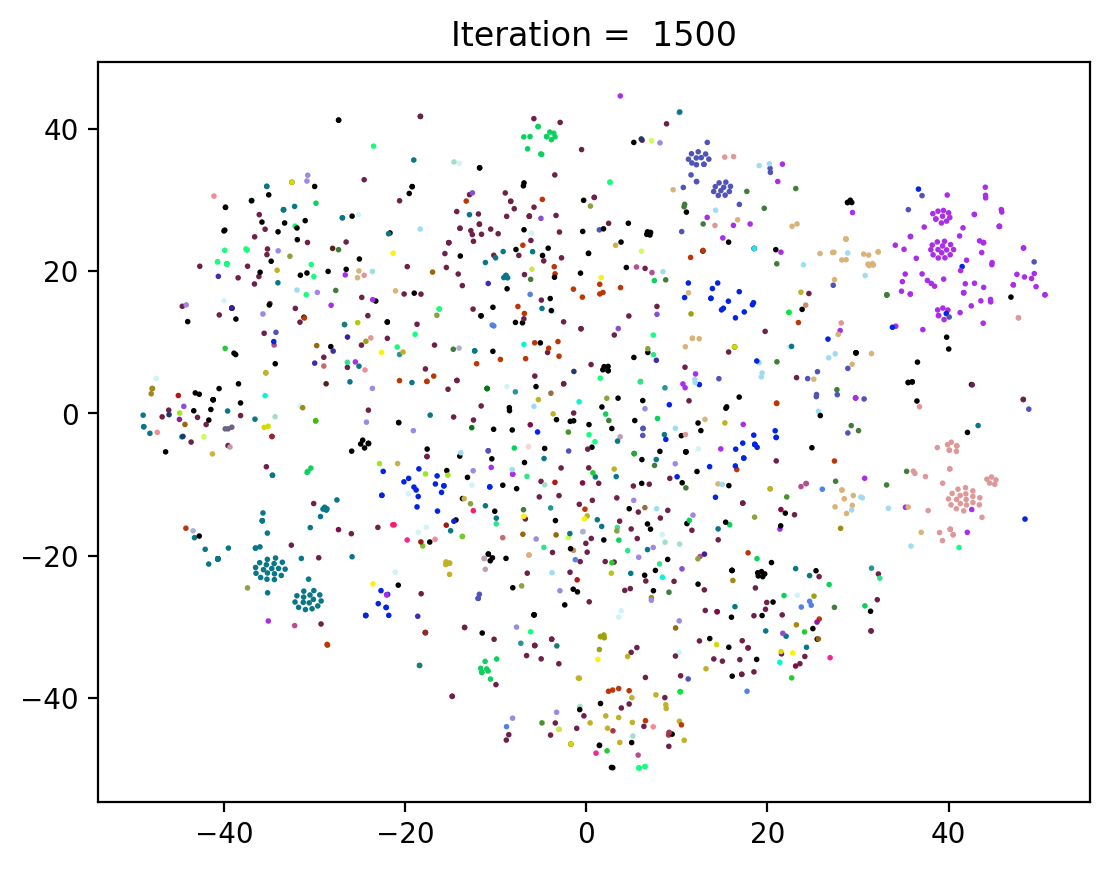

 1500 --   0.83  --  10.60 --  0.400  
 1510 --   0.83  --  10.56 --  0.404  
 1520 --   0.83  --  10.53 --  0.410  
 1530 --   0.83  --  10.88 --  0.402  
 1540 --   0.83  --  10.62 --  0.400  
 1550 --   0.83  --  10.58 --  0.401  
 1560 --   0.83  --  10.61 --  0.399  
 1570 --   0.83  --  10.60 --  0.405  
 1580 --   0.84  --  10.74 --  0.401  
 1590 --   0.83  --  10.63 --  0.401  


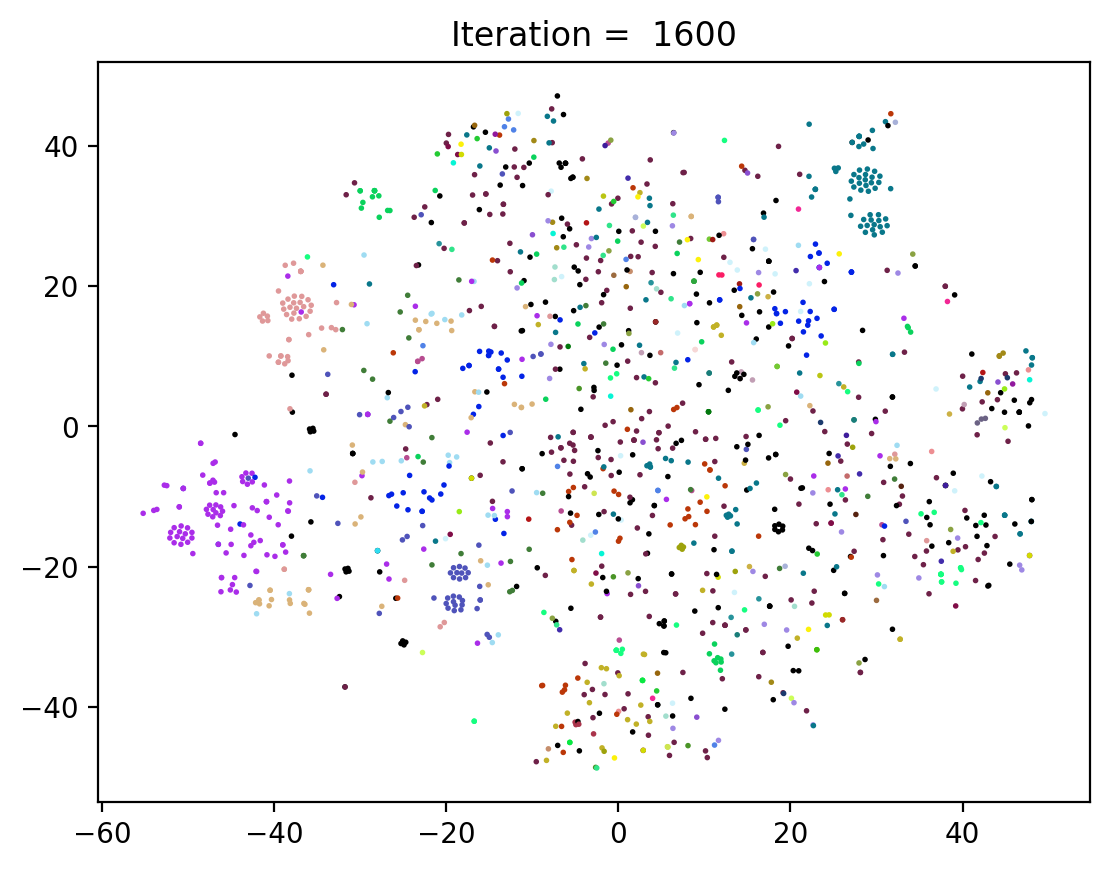

 1600 --   0.83  --  10.61 --  0.403  
 1610 --   0.83  --  10.63 --  0.398  
 1620 --   0.82  --  10.62 --  0.397  
 1630 --   0.82  --  10.61 --  0.404  
 1640 --   0.83  --  10.58 --  0.405  
 1650 --   0.83  --  10.56 --  0.401  
 1660 --   0.83  --  10.56 --  0.403  
 1670 --   0.82  --  10.65 --  0.399  
 1680 --   0.83  --  10.59 --  0.406  
 1690 --   0.83  --  10.58 --  0.398  


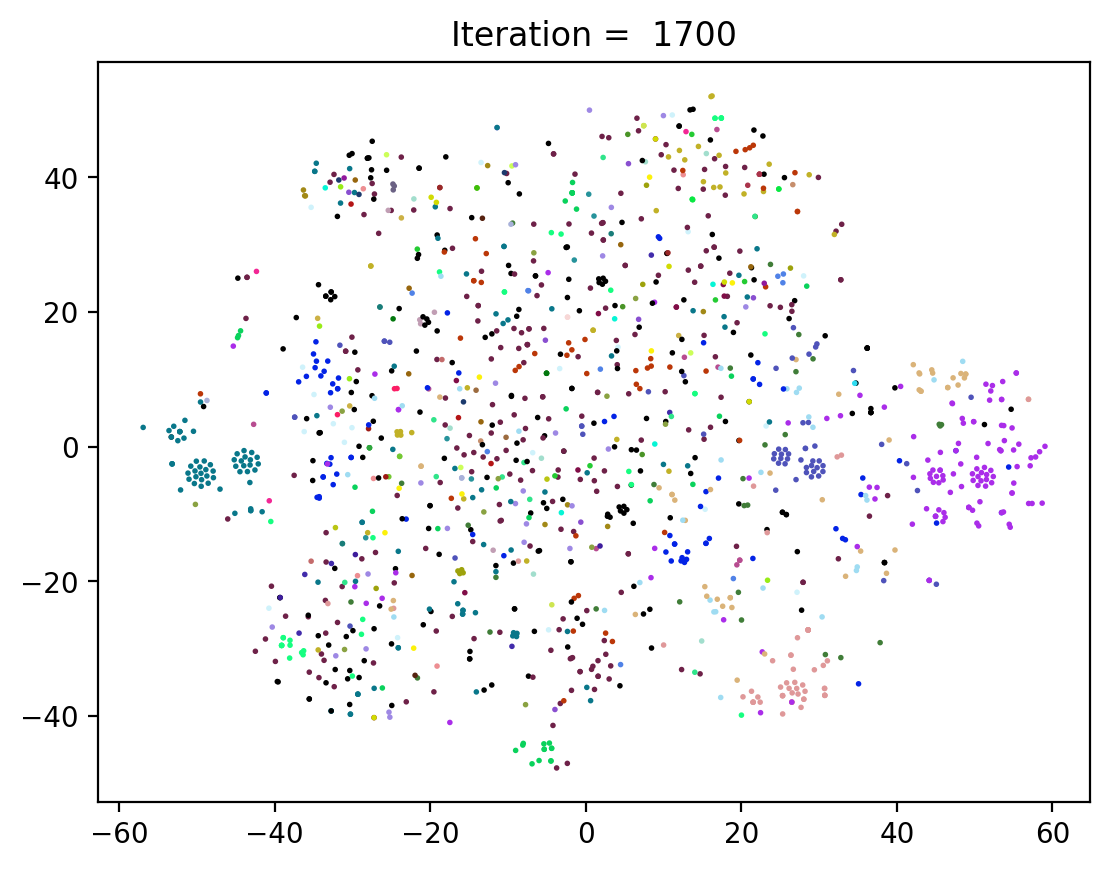

 1700 --   0.83  --  10.37 --  0.401  
 1710 --   0.83  --  10.48 --  0.408  
 1720 --   0.82  --  10.46 --  0.399  
 1730 --   0.83  --  10.48 --  0.398  
 1740 --   0.83  --  10.61 --  0.399  
 1750 --   0.83  --  10.52 --  0.397  
 1760 --   0.82  --  10.73 --  0.402  
 1770 --   0.82  --  10.60 --  0.406  
 1780 --   0.82  --  10.52 --  0.408  
 1790 --   0.82  --  10.57 --  0.407  


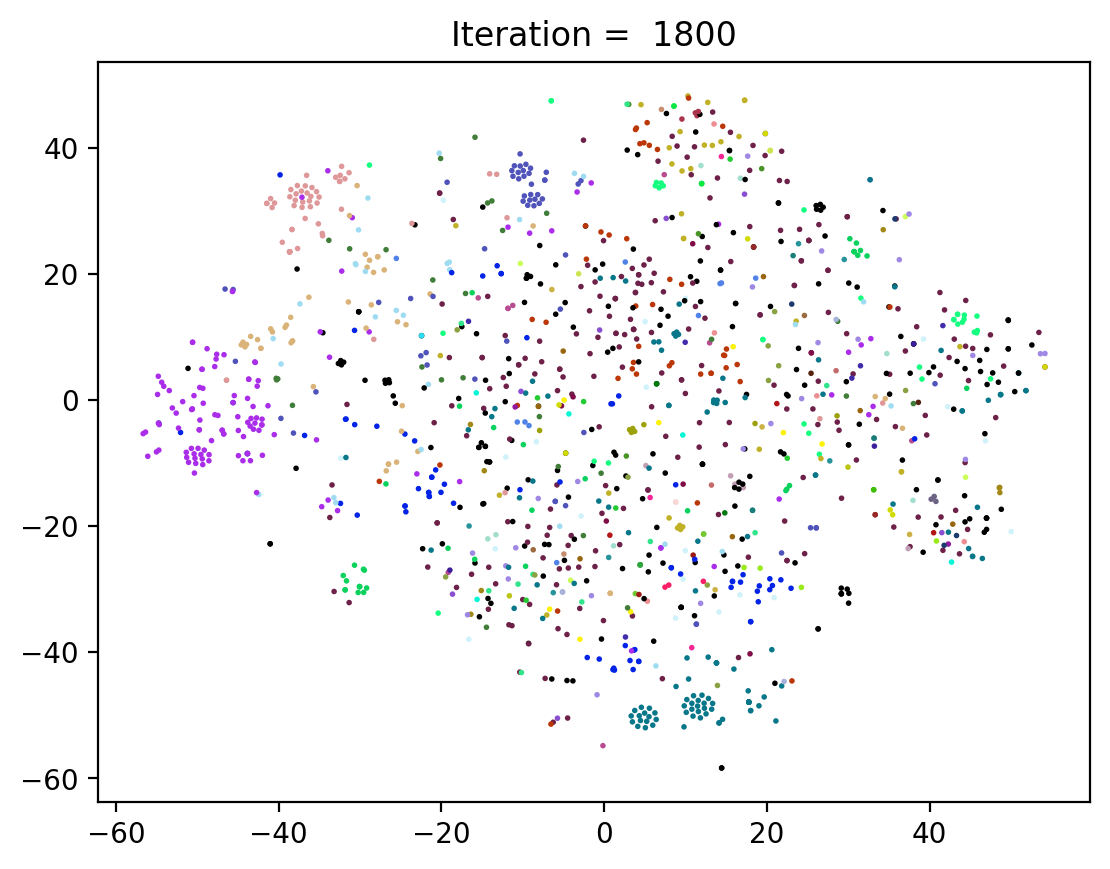

 1800 --   0.82  --  10.53 --  0.401  
 1810 --   0.82  --  10.47 --  0.409  
 1820 --   0.83  --  10.47 --  0.408  
 1830 --   0.82  --  10.46 --  0.406  
 1840 --   0.82  --  10.47 --  0.402  
 1850 --   0.81  --  10.61 --  0.413  
 1860 --   0.82  --  10.65 --  0.407  
 1870 --   0.82  --  10.60 --  0.405  
 1880 --   0.81  --  10.51 --  0.408  
 1890 --   0.81  --  10.67 --  0.407  


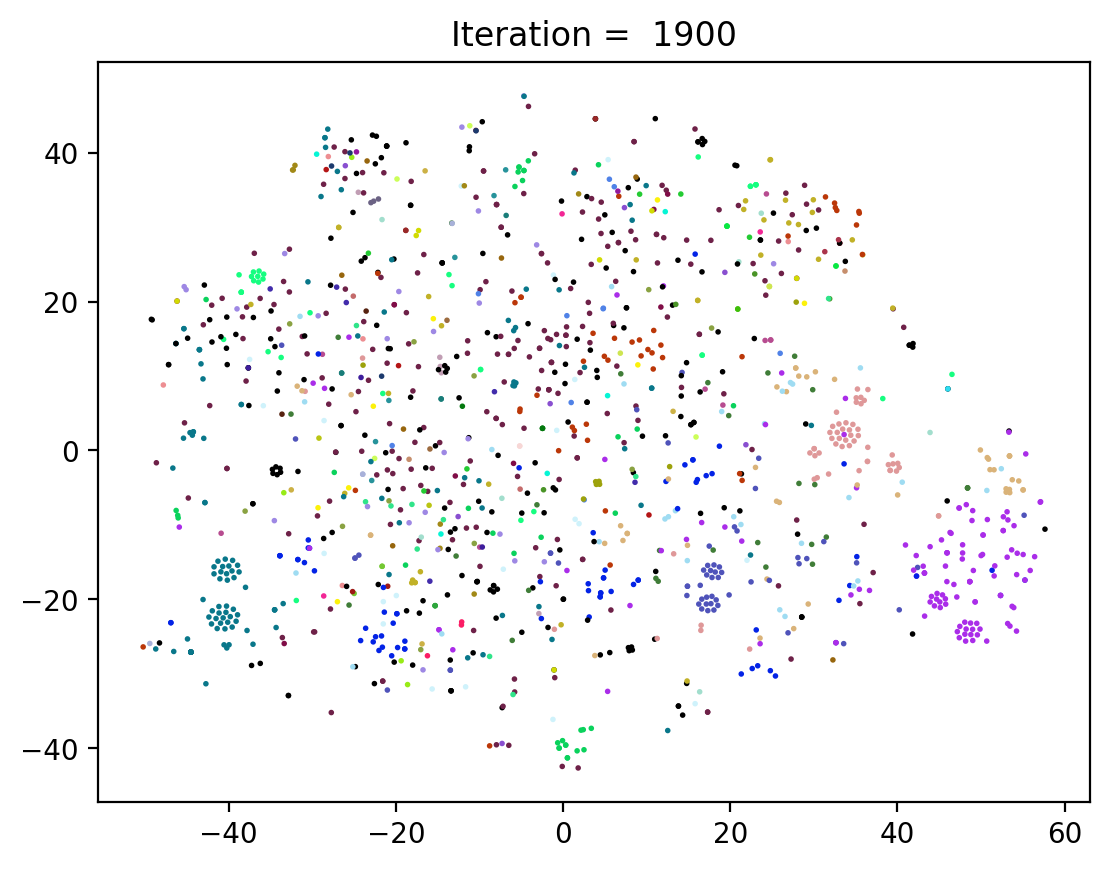

 1900 --   0.82  --  10.64 --  0.410  
 1910 --   0.82  --  10.64 --  0.409  
 1920 --   0.82  --  10.72 --  0.413  
 1930 --   0.82  --  10.65 --  0.407  
 1940 --   0.82  --  10.52 --  0.409  


In [ ]:
train_ids = np.arange(len(embs_tcra))[0::2]
test__ids = np.arange(len(embs_tcra))[1::2]

for iteration in range(2_200):
    if iteration % 10 == 0:
        with torch.no_grad():
            model.eval()
            # test__batch = np.random.choice(test__ids, 4096)
            test__batch = test__ids
            emb, _, test_loss, test_fraction = compute_loss(test__batch)
            if iteration % 100 == 0 or iteration in [10, 20, 40, 70]:
                visualize(emb, peptide_ids[test__batch])

    model.train()
    # train_batch = np.random.choice(train_ids, 4096)
    train_batch = train_ids
    _, _, train_loss, _ = compute_loss(train_batch)
    optim.zero_grad()
    train_loss.backward()
    optim.step()
    if iteration % 10 == 0:
        print(f'{iteration:>5} -- {train_loss:6.2f}  -- {test_loss:6.2f} -- {test_fraction:6.3f}  ')

In [ ]:
def compute_loss_other(indices):
    left_emb = model(torch.from_numpy(embs_tcra[indices]).to(device))
    rght_emb = model(torch.from_numpy(embs_tcrb[indices]).to(device))
    pepts = peptide_ids[indices]

    logits = torch.einsum('i c, j c -> i j', left_emb, rght_emb)
    target = torch.arange(len(indices), device=device)
    loss_left = torch.nn.functional.cross_entropy(logits, target)
    loss_rght = torch.nn.functional.cross_entropy(logits.T, target)

    probs = (torch.softmax(logits, dim=0) + torch.softmax(logits, dim=1)) / 2

    _, pept_ids, n_recognized_counts = np.unique(pepts, return_inverse=True, return_counts=True)
    n_recognized = np.zeros(len(n_recognized_counts))
    for i in range(len(pept_ids)):
        n_recognized[pept_ids[i]] += probs[i, pept_ids == pept_ids[i]].sum()

    return left_emb + rght_emb, logits, (loss_left + loss_rght) * 0.5, n_recognized, n_recognized_counts

In [ ]:
from copy import deepcopy
torch.save(model, 'model-1200-many-positives-in-single')
# model1 = deepcopy(model)

In [ ]:
*_, nom, denom = compute_loss_other(test__ids)
order = np.argsort(denom)[::-1]

In [ ]:
for alpha in [0.6, 0.1]:
    fig, ax1 = plt.subplots()
    
    color = 'tab:green'
    ax1.set_xlabel('peptide (sorted by TCRs)')
    ax1.set_ylabel('match-score', color=color)
    ax1.plot(
        (nom / denom)[order], color=color, alpha=alpha)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Number of TCRs in test', color=color)  # we already handled the x-label with ax1
    ax2.plot(
        denom[order], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.semilogy()
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()